In [29]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


## CNN Setting

In [32]:
# Hyperparameters

batch_size = 3000
learning_rate = 0.005
epoch_num = 30

In [ ]:
# Load MNIST dataset
train_data = datasets.MNIST(root = './MNIST_data/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

test_data = datasets.MNIST(root = './MNIST_data/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

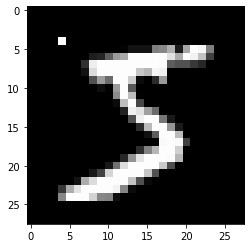

In [38]:
import numpy as np

image, label = train_data[0]
shapes = image.squeeze().shape

center = np.random.randint(1,(shapes[0]-2),2) # 1에서 26사이 2개

image = image.squeeze().numpy()

image[center[0],center[1]] = 1  # 점 찍기

plt.imshow(image, cmap='gray')

In [50]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True
)

### CNN Model

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode, dilation, groups, bias)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding="same",
        )
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding="same")
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000)  # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim = 1)


classification_model = CNN().to(device)
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [52]:
classification_model.train()    # train mode
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = classification_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    #epoch마다 loss 출력
    print('Epoch : {} \tLoss : {:.6f}'.format(epoch, loss.item()))

Epoch : 0 	Loss : 2.174981
Epoch : 1 	Loss : 2.147637
Epoch : 2 	Loss : 1.793685
Epoch : 3 	Loss : 1.775841
Epoch : 4 	Loss : 1.759803
Epoch : 5 	Loss : 1.757428
Epoch : 6 	Loss : 1.758481
Epoch : 7 	Loss : 1.749619
Epoch : 8 	Loss : 1.744121
Epoch : 9 	Loss : 1.667704
Epoch : 10 	Loss : 1.657732
Epoch : 11 	Loss : 1.658432
Epoch : 12 	Loss : 1.656346
Epoch : 13 	Loss : 1.658827
Epoch : 14 	Loss : 1.647263
Epoch : 15 	Loss : 1.637115
Epoch : 16 	Loss : 1.569972
Epoch : 17 	Loss : 1.567602
Epoch : 18 	Loss : 1.550052
Epoch : 19 	Loss : 1.475710
Epoch : 20 	Loss : 1.473871
Epoch : 21 	Loss : 1.469015
Epoch : 22 	Loss : 1.471248
Epoch : 23 	Loss : 1.467474
Epoch : 24 	Loss : 1.467254
Epoch : 25 	Loss : 1.471229
Epoch : 26 	Loss : 1.467386
Epoch : 27 	Loss : 1.465493
Epoch : 28 	Loss : 1.465832
Epoch : 29 	Loss : 1.466300


In [53]:
classification_model.eval()    # 평가시에는 dropout이 OFF 된다.

correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = classification_model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set Accuracy : 99.21%


CNN 모델 저장

In [54]:
torch.save(classification_model.state_dict(), './model/classification_model.pt')

CNN 모델 불러오기

In [55]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode, dilation, groups, bias)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding="same",
        )
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding="same")
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000)  # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim = 1)


classification_model = CNN().to(device)
classification_model.load_state_dict(torch.load('./model/classification_model.pt'))

<All keys matched successfully>

### MNIST Environment

In [146]:
import numpy as np

class MnistEnv():
    def __init__(self, classification_model=classification_model, random=True):
        super().__init__()
        self.classification_model = classification_model  # pre-trained CNN model

    def step(self, original_image, action):  # action = [위치, 밝기]
        action = torch.tensor(action)
        action = torch.sigmoid(action)

        point = (action[:, 0] * 676).int()
        brightness = ((action[:, 1] * 255).int()) / 255

        arr = []
        center = [torch.div(point, 26, rounding_mode="trunc") + 1, point % 26 + 1]
        action = [point, brightness]

        for i in range(batch_size):
            changed_image = original_image[i].squeeze().squeeze().cpu().numpy()  #   [28,28]
            # Stamp 찍기
            changed_image[center[0][i], center[1][i]] = brightness[i]
            arr.append(changed_image)

        changed_images = torch.stack([torch.tensor(a).unsqueeze(0) for a in arr], dim=0)

        with torch.no_grad():
            original_outputs = self.classification_model(original_image.to(device))
            changed_outputs = self.classification_model(changed_images.to(device))

        rewards = torch.sum(
            torch.nn.functional.kl_div(
                original_outputs.log(), changed_outputs, size_average = None, reduction="none"
            ),
            dim=1,
        )

        # original_outputs와 changed_outputs의 max의 index가 같으면 reward를 -1/reward로 준다.
        rewards[original_outputs.max(1)[1] == changed_outputs.max(1)[1]] = (
            -1 / rewards[original_outputs.max(1)[1] == changed_outputs.max(1)[1]]
        )

        rewards[rewards < -1000] = -1000
        rewards[rewards > 1000] = 1000

        rewards = torch.nan_to_num(rewards, nan=0.0, posinf=1000, neginf=-1000) # nan을 0으로, inf를 100으로 바꾼다.

        return rewards.cpu().numpy()

### RL model

In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [149]:
#Hyperparameters
num_seeds = 10
action_size = 2
RL_epoch = 100


env_name = "MnistEnv-v1"
agent_name = "REINFORCE"

In [150]:
import numpy as np
from math import floor
from typing import Tuple
import random

RL_learning_rate = 0.00000000001


class REINFORCE(nn.Module):
    def __init__(self, opt):
        super(REINFORCE, self).__init__()

        self.data = []

        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding="same")
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding="same")

        self.fc1 = nn.Linear(3136, 1024)  # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1024, 1024)

        self.fc_mu = torch.nn.Linear(1024, action_size)
        self.fc_std = torch.nn.Linear(1024, action_size)

        self.dropout = nn.Dropout2d(0.25)
        self.optimizer = optim.Adam(self.parameters(), lr=RL_learning_rate)

    def forward(self, state):
        state = self.conv1(state)  # conv1
        state = F.relu(state)
        state = F.max_pool2d(state, 2)
        state = self.conv2(state)  # conv2
        state = F.relu(state)
        state = F.max_pool2d(state, 2)
        state = self.dropout(state)
        state = torch.flatten(state, 1)
        state = self.fc1(state)  # fc1
        state = F.relu(state)
        state = self.fc2(state)  # fc2
        state = F.relu(state)
        mu = self.fc_mu(state)
        std = self.fc_std(state)

        # sigmoid를 통해 0~1사이의 값으로 만들어주며, softplus를 통해 0~무한대의 값으로 만들어준다.
        return torch.sigmoid(mu), F.softplus(std)

    def put_data(self, transition):
        self.data.append(transition)

    def train_net(self):
        self.optimizer.zero_grad()
        r_lst, log_prob_lst = [], []
        for transition in self.data:
            r_lst.append(transition[0])
            log_prob_lst.append(transition[1])
        r_lst = torch.tensor(r_lst).to(device)
        log_prob_lst = torch.stack(log_prob_lst).to(device)
        log_prob_lst = (-1) * log_prob_lst
        loss = log_prob_lst * r_lst
        loss.mean().backward()
        self.optimizer.step()
        self.data = []

In [151]:
import random

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # manual_seed는 CPU에 사용되는 난수 생성기의 시드를 설정합니다.
    torch.cuda.manual_seed(seed) # cuda.manual_seed는 GPU에 사용되는 난수 생성기의 시드를 설정합니다.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True # cudnn.deterministic은 cudnn의 결과를 동일하게 만듭니다.

Training Start
epoch : 1 / 100 | epoch_score : -101.04
epoch : 2 / 100 | epoch_score : -96.40
epoch : 3 / 100 | epoch_score : -113.06
epoch : 4 / 100 | epoch_score : -101.92
epoch : 5 / 100 | epoch_score : -109.76
epoch : 6 / 100 | epoch_score : -106.55
epoch : 7 / 100 | epoch_score : -106.02
epoch : 8 / 100 | epoch_score : -101.98
epoch : 9 / 100 | epoch_score : -95.96
epoch : 10 / 100 | epoch_score : -98.10
epoch : 11 / 100 | epoch_score : -98.96
epoch : 12 / 100 | epoch_score : -102.98
epoch : 13 / 100 | epoch_score : -103.32
epoch : 14 / 100 | epoch_score : -99.19
epoch : 15 / 100 | epoch_score : -103.82
epoch : 16 / 100 | epoch_score : -105.68
epoch : 17 / 100 | epoch_score : -100.93
epoch : 18 / 100 | epoch_score : -108.20
epoch : 19 / 100 | epoch_score : -97.28
epoch : 20 / 100 | epoch_score : -96.82
epoch : 21 / 100 | epoch_score : -99.75
epoch : 22 / 100 | epoch_score : -100.26
epoch : 23 / 100 | epoch_score : -99.47
epoch : 24 / 100 | epoch_score : -101.11
epoch : 25 / 100 | 

FileNotFoundError: [Errno 2] No such file or directory: './model/1e-11/random_seed_2999.pt'

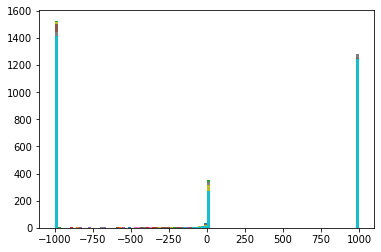

In [152]:
import math
from torch.distributions import Normal
import matplotlib.pyplot as plt
import wandb

score_arr = []
epoch_score_arr = []
temp = []

def main():
    env = MnistEnv()
    score = 0.0
    epoch_score = 0.0
    RL_learning_rate = 0.00000000001

    print("Training Start")

    for i in range(10):
        policy = REINFORCE().to(device)
        seed_all(i)
        for epoch in range(RL_epoch):
            for s, target in train_loader:
                # s의 자료형을 UNIT8로 바꾼다. (uint8은 0~255사이의 값으로 이루어진 자료형이다.)
                s *= 255
                s = s.type(torch.uint8).to(device)/255
                x_range = torch.linspace(-1,1,28)
                y_range = torch.linspace(-1,1,28)
                y,x = torch.meshgrid(x_range,y_range)
                y = y.expand([batch_size,1,-1,-1])
                x = x.expand([batch_size,1,-1,-1])
                normalized_coord= torch.cat([x,y],dim=1) # [batch_size,2,28,28]
                s_normalized = torch.cat([s,normalized_coord.to(device)],dim=1) # [batch_size,3,28,28]
                
                mu, std = policy(s_normalized.type(torch.float32))

                m_1 = Normal(mu[:, 0], std[:, 0])
                m_2 = Normal(mu[:, 1], std[:, 1])

                action_1 = m_1.sample()
                action_2 = m_2.sample()

                action = torch.stack([action_1, action_2], dim=1)  # point, brightness

                log_prob_1 = m_1.log_prob(action_1)
                log_prob_2 = m_2.log_prob(action_2)

                log_prob = log_prob_1 + log_prob_2

                r = env.step(s.type(torch.float32), action.cpu().numpy())
                temp = r
                
                epoch_score += np.sum(r)
                r = r / 1000.0
                for i in range(batch_size):
                    policy.put_data(
                        [r[i], log_prob[i]]
                    )  # transation = (reward, log_prob)
                policy.train_net()

            # 소수점 4자리까지 출력
            print(
                "epoch : {} / {} | epoch_score : {:.2f}".format(
                    epoch + 1, RL_epoch, epoch_score / len(train_data)
                )
            )
            plt.hist(temp, bins=100)
            plt.savefig(f'{epoch} epoch rewards histogram.png')
            epoch_score_arr.append(epoch_score / len(train_data))
            epoch_score = 0.0
        # 모델 저장
        torch.save(
            policy.state_dict(), f"./model/{RL_learning_rate}/random_seed_{i}.pt"
        )
if __name__ == "__main__":
    main()

In [ ]:
import math
from torch.distributions import Normal

# 모델 불러오기
policy = REINFORCE().to(device)
policy.load_state_dict(torch.load('./model/adverserial_RL_model.pt'))

<All keys matched successfully>

In [145]:
import torch.nn.functional as F

P = torch.Tensor([[0.0, 0.84, 0.16], [0.0, 0.84, 0.16]])
Q = torch.Tensor([[0.333, 0.333, 0.333], [0.333, 0.333, 0.333]])

# kl_div(input,target) :input은 log_scale로 들어가야 함
print(torch.sum(F.kl_div(Q.log(), P, reduction="none"), dim=1))

tensor([0.6599, 0.6599])
